### Updated on 24 May, 2023

# 1. Table of contents<a class ="anchor" id="0.Contents"></a>

* [1. Table of contents](#0.Contents)
    * [1.1. Introduction](#Intro)
* [2. Import Dependent Libraries](#1.Import)
* [3. Importing 311 Service Requests Data](#2.Import_data)
    * [3.1. Import data from Socrata Open Data API (Soda)](#2.1.Import_data1)
      * [3.1.1. Scrubbing the Data](#2.1.1.Scrub_import_data1)
      * [3.1.2. Saving the Cleaned Data on Google Drive](#2.1.2.Save_import_data1)
    * [3.2. Google-colab authorization and importing data from Google Drive](#2.2.Import_data2)
    * [3.3. Importing JSON objects using API and flattening ](#2.3.Import_data3)
    * [3.4. Importing data from a csv file in a local directory](#2.4.Import_data4)
* [4. Plot to check for missing values](#3.missing_values)
    * [comments](#comment1)
* [5. 2023 Reporting](#4.2023_Reporting)
    * [5.1. Analysis-1](#4.1.Q1)
        * [5.1.2. Plot of top 10 complaints in NYC in 2023](#4.1.2.Fig1)
        * [5.1.4.  Plot of top 10 complaint types by each borough in 2023](#4.1.4.Fig2)
            * [comments](#comment2)
    * [5.2. Analysis-2](#4.2.Q2)
        * [4.2.6. Plot of Complaint-index (total complaints relative to their population) for each Borough in 2023](#4.2.6.Fig3)
            * [comments](#comment3)
    * [5.3. Analysis-3](#4.3.Q3)
        * [5.3.4. Plot of Complaint-index (total complaints relative to their population) of the two complaint types for each Borough in NYC in 2023'](#4.3.4.Fig4)
            * [comments](#comment4)
* [6. Time Series/Exploratory Analysis](#5.TS)
    * [6.1. Analysis-4](#5.1.Q1)
        * [6.1.5. Monthly plot of complaint-rates by each Borough between 2010 and 2021](#5.1.5.Fig5)
        * [6.1.7. Monthly plot of complaint-rates for NYC between 2010 and 2021](#5.1.7.Fig6)
            * [comments](#comment5)
    * [6.2. Analysis-5](#5.2.Q2)
        * [6.2.2. Scatter plot of Complaint rate vs Complaint Index to look for anomalies/outliers](#5.2.2.Fig6)
            * [comments](#comment6)
        * [6.2.3. Zip codes with highest complaint rates before and after winsorization](#5.2.3.Tab1)
            * [comments](#comment7)
* [7. Animation of complaints in NYC by each month in 2021](#animation)

# 1.1. Introduction<a class="anchor" id="Intro"></a>

The objective of this project is to analyze recent data on NYC 311 calls and develop a neural network capable of classifying the agency that responded to each call. By examining the content, timing, frequency, and location of the issues raised by 311 callers, government agencies and local policy stakeholders can better serve NYC residents. Through exploratory analysis and visualization of public 311 data, this project aims to contribute to this understanding. The modeling section focuses on demonstrating a proof-of-concept tool that efficiently connects residents to the appropriate government services.

In this analysis, I analyze the 311 service request data for New York city between the years 2010 and 2021. The full dataset has 25,839,156 rows and 46 columns. I will use only the first 1.5 million records for my analysis due to limitations on computational resources.

# 2. Import Dependent Libraries<a class="anchor" id="1.Import_libraries"></a>

In [3]:
import pandas as pd
import numpy as np
import datetime as dt

%matplotlib inline
import matplotlib.pyplot as plt
import plotly as px
import seaborn as sns 
import requests
import json
import warnings

from matplotlib import style
from google.colab import drive
warnings.filterwarnings("ignore")

# 3. Importing 311 Service Requests Data <a class="anchor" id="2.Import_data"></a>
Note: Data source details are in the README.md file. \
Data imports can be done in either of the below 4 methods

#### 3.1. Import data from Socrata Open Data API (Soda)  <a class="anchor" id="2.1.Import_data1"></a>

In [1]:
# !pip install sodapy #install sodapy from pip and then import dataset
from sodapy import Socrata

app_token = "XXX" # enter your app token here
client = Socrata("data.cityofnewyork.us", app_token)
client.timeout = 1000
results = client.get("erm2-nwe9", limit=500000)

##### 3.1.1. Scrubbing the Data  <a class="anchor" id="2.1.1.Scrub_import_data1"></a>

In [4]:
df = pd.DataFrame.from_records(results)

# Include only the essential columns
df = df[['unique_key', 'created_date', 'closed_date', 'agency', 'complaint_type', 'descriptor', 'borough',
         'incident_zip','latitude', 'longitude', 'location']]

# Drop observations of boroughs not in the below list
Borough_list = ['BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND']
df = df[df['borough'].isin(Borough_list)] 

# Eliminate rows without lat/long and location type data
df = df[df.latitude.notnull()]
df = df[df.longitude.notnull()]
df = df[df.descriptor.notnull()]

df.head()

,unique_key,created_date,closed_date,agency,complaint_type,descriptor,borough,incident_zip,latitude,longitude,location
0,57729980,2023-05-28T12:00:00.000,NaN,DSNY,Derelict Vehicles,Derelict Vehicles,QUEENS,11357,40.77821342654645,-73.82385968706518,"{'latitude': '40.77821342654645', 'longitude':..."
1,57724410,2023-05-28T12:00:00.000,NaN,DSNY,Derelict Vehicles,Derelict Vehicles,BROOKLYN,11226,40.646437257782,-73.96349236479078,"{'latitude': '40.646437257782', 'longitude': '..."
2,57731994,2023-05-28T12:00:00.000,NaN,DSNY,Derelict Vehicles,Derelict Vehicles,BROOKLYN,11217,40.675906089553244,-73.9776588907734,"{'latitude': '40.675906089553244', 'longitude'..."
3,57727889,2023-05-28T01:07:49.000,NaN,NYPD,Illegal Parking,Paper License Plates,QUEENS,11357,40.77821342654645,-73.82385968706518,"{'latitude': '40.77821342654645', 'longitude':..."
4,57728964,2023-05-28T01:07:34.000,NaN,EDC,Noise - Helicopter,Other,BROOKLYN,11231,40.68019279491008,-73.99641985682297,"{'latitude': '40.68019279491008', 'longitude':..."


##### 3.1.2. Saving the Cleaned Data on Google Drive  <a class="anchor" id="2.1.2.Save_import_data1"></a>

In [5]:
from pydrive.auth import GoogleAuth #!pip install -U -q PyDrive
from pydrive.drive import GoogleDrive
from google.colab import auth #!pip install google-colab
from oauth2client.client import GoogleCredentials

from google.colab import drive
drive.mount('/content/gdrive')

# Export files to google drive
df.to_csv('/content/gdrive/My Drive/Colab Notebooks/311_Service_Request_Analysis/311_Service_Requests.csv', index = False)

Mounted at /content/gdrive


In [6]:
# Import files from google drive
data = pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/311_Service_Request_Analysis/311_Service_Requests.csv')

#### 3.2. Google-colab authorization and importing data from Google Drive <a class="anchor" id="2.2.Import_data2"></a>

```python
from pydrive.auth import GoogleAuth #!pip install -U -q PyDrive
from pydrive.drive import GoogleDrive
from google.colab import auth #!pip install google-colab
from oauth2client.client import GoogleCredentials

#to import files from google drive
from google.colab import drive
drive.mount('/content/gdrive')
df=pd.read_csv('/content/gdrive/My Drive/Colab Notebooks/311_Service_Requests_from_2010_to_Present.csv')

#authorization-not required if done manually
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
```

#### 3.3. Importing JSON objects using API and flattening <a class="anchor" id="2.3.Import_data3"></a>
#### --Only imports first 1000 obs--

```python
import requests
import json
Data_API = requests.get('https://data.cityofnewyork.us/resource/erm2-nwe9.json')
Data = Data_API.text
parse_json=json.loads(Data) #parses the json objects
df = json_normalize(parse_json) #flatterns the json object to form a dataframe
```

#### 3.4. Importing data from a csv file in a local directory<a class="anchor" id="2.4.Import_data4"></a>

```python
df = pd.read_csv('311_Service_Requests_from_2010_to_Present.csv')

# Include only the essential columns
df = df[['Unique Key', 'Created Date', 'Closed Date', 'Agency', 'Complaint Type', 'Descriptor', 'Borough',
         'Incident Zip','Latitude', 'Longitude', 'Location']]

# Drops observations of boroughs not in the below list
Borough_list=['BRONX','BROOKLYN','MANHATTAN','QUEENS','STATEN ISLAND']
df = df[df['Borough'].isin(Borough_list)] 
df = pd.read_csv('df.csv')
```

# 4. Plot to check for missing values<a class="anchor" id="3.missing_values"></a>

####      Note: yellow color in the below plot represents missing values

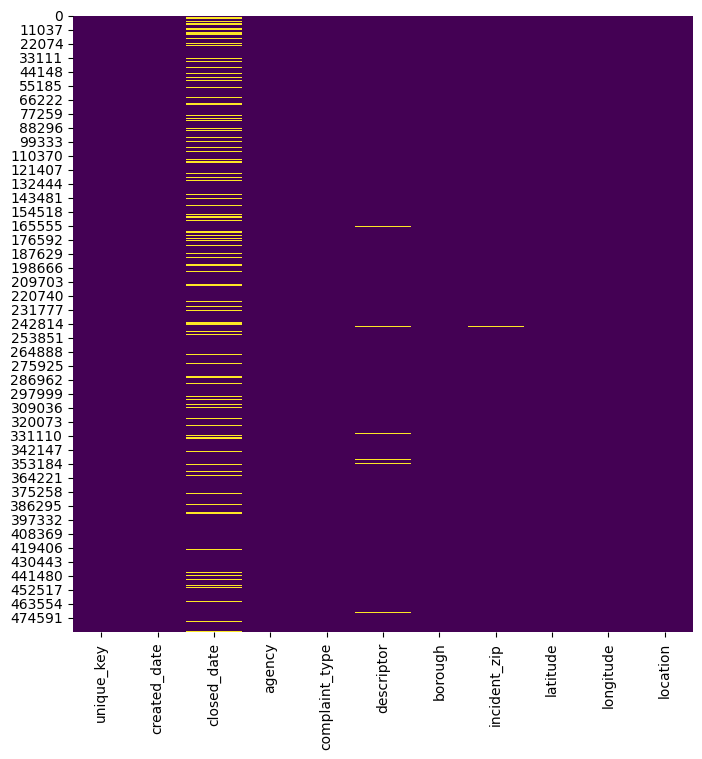

In [7]:
plt.figure(figsize=(8, 8))      # figsize in inches
sns.heatmap(data.isnull(),xticklabels=True,cbar=False,cmap='viridis') # heat map of missing data
plt.show()

<a class="anchor" id="comment1"></a> **Observation:** From the above plot, it seems like there are not many missing observations in the key variables about to be used in this analysis. But I will deal with them later in the analysis.

# 5. 2023 Reporting<a class="anchor" id="4.2023_Reporting"></a>

### <a class="anchor" id="4.1.Q1"></a> 5.1. Analysis-1: For the 10 most common overall complaint type, how many of each of those 10 types were there in 2023 for each borough?

#### <a class="anchor" id="4.1.1"></a> 5.1.1. Create year-month, year and month variables

In [8]:
data['Year_month'] = pd.DatetimeIndex(data['created_date']).strftime('%Y-%m')
data['Year'] = pd.DatetimeIndex(data['created_date']).year #creates year variable
data['Month'] = pd.DatetimeIndex(data['created_date']).month #creates month variable
data.head()

,unique_key,created_date,closed_date,agency,complaint_type,descriptor,borough,incident_zip,latitude,longitude,location,Year_month,Year,Month
0,57729980,2023-05-28T12:00:00.000,NaN,DSNY,Derelict Vehicles,Derelict Vehicles,QUEENS,11357.0,40.778213,-73.823860,"{'latitude': '40.77821342654645', 'longitude':...",2023-05,2023,5
1,57724410,2023-05-28T12:00:00.000,NaN,DSNY,Derelict Vehicles,Derelict Vehicles,BROOKLYN,11226.0,40.646437,-73.963492,"{'latitude': '40.646437257782', 'longitude': '...",2023-05,2023,5
2,57731994,2023-05-28T12:00:00.000,NaN,DSNY,Derelict Vehicles,Derelict Vehicles,BROOKLYN,11217.0,40.675906,-73.977659,"{'latitude': '40.675906089553244', 'longitude'...",2023-05,2023,5
3,57727889,2023-05-28T01:07:49.000,NaN,NYPD,Illegal Parking,Paper License Plates,QUEENS,11357.0,40.778213,-73.823860,"{'latitude': '40.77821342654645', 'longitude':...",2023-05,2023,5
4,57728964,2023-05-28T01:07:34.000,NaN,EDC,Noise - Helicopter,Other,BROOKLYN,11231.0,40.680193,-73.996420,"{'latitude': '40.68019279491008', 'longitude':...",2023-05,2023,5


#### <a class="anchor" id="4.1.2.Fig1"></a>5.1.2. Plot of top 10 complaints in NYC in 2023 

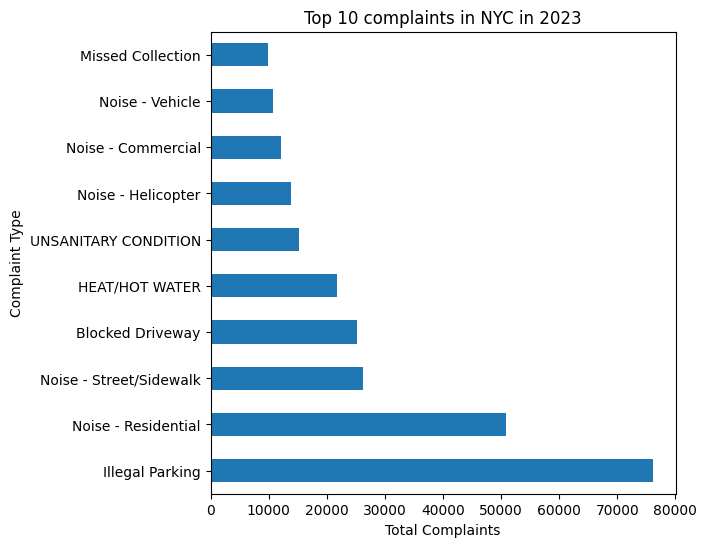

In [9]:
df_subset = data[data['Year']==2023] #subset the original dataset to a new one with only year 2023 obs 
df_subset.shape

# # Save the filtered dataset in Google Drive
# df_subset.to_csv('/content/gdrive/My Drive/Colab Notebooks/311_Service_Request_Analysis/df_subset.csv', index=False) 

top_complaints = df_subset['complaint_type'].value_counts()[:10].index.tolist() # list with names of the top 10 complaints
plt.figure(figsize=(6,6)) # figsize in inches
df_subset['complaint_type'].value_counts()[:10].plot(kind='barh') #plot function that plots frequency
plt.xlabel('Total Complaints')
plt.ylabel('Complaint Type')
plt.title('Top 10 complaints in NYC in 2023')
plt.show()

#### 5.1.3. Number of complaints of the top 10 complaint types by each borough in 2023

In [10]:
# Filter the observations having complaint type from the top complaints list
df_subset2 = df_subset[df_subset['complaint_type'].isin(top_complaints)] 
df_subset3 = df_subset2.groupby(['complaint_type','borough']) # grouping by 2 columns -'Complaint Type','Borough'
df_subset4 = df_subset3.size().unstack() # Borough-level complaint frequency
df_subset4.reset_index(inplace=False) # converts labels to column
df_subset4

borough,BRONX,BROOKLYN,MANHATTAN,QUEENS,STATEN ISLAND
complaint_type,,,,,
Blocked Driveway,4124,9382,751,10328,610
HEAT/HOT WATER,7244,5648,5589,2989,254
Illegal Parking,11701,28620,11261,22469,2161
Missed Collection,754,3512,1010,3461,1197
Noise - Commercial,1584,4002,4178,2175,226
Noise - Helicopter,11,3470,8110,2255,9
Noise - Residential,12880,14619,9916,11944,1476
Noise - Street/Sidewalk,7440,6178,8678,3776,239
Noise - Vehicle,2886,2596,2752,2435,164


#### <a class="anchor" id="4.1.4.Fig2"></a>5.1.4.  plot of top 10 complaint types by each borough in 2023

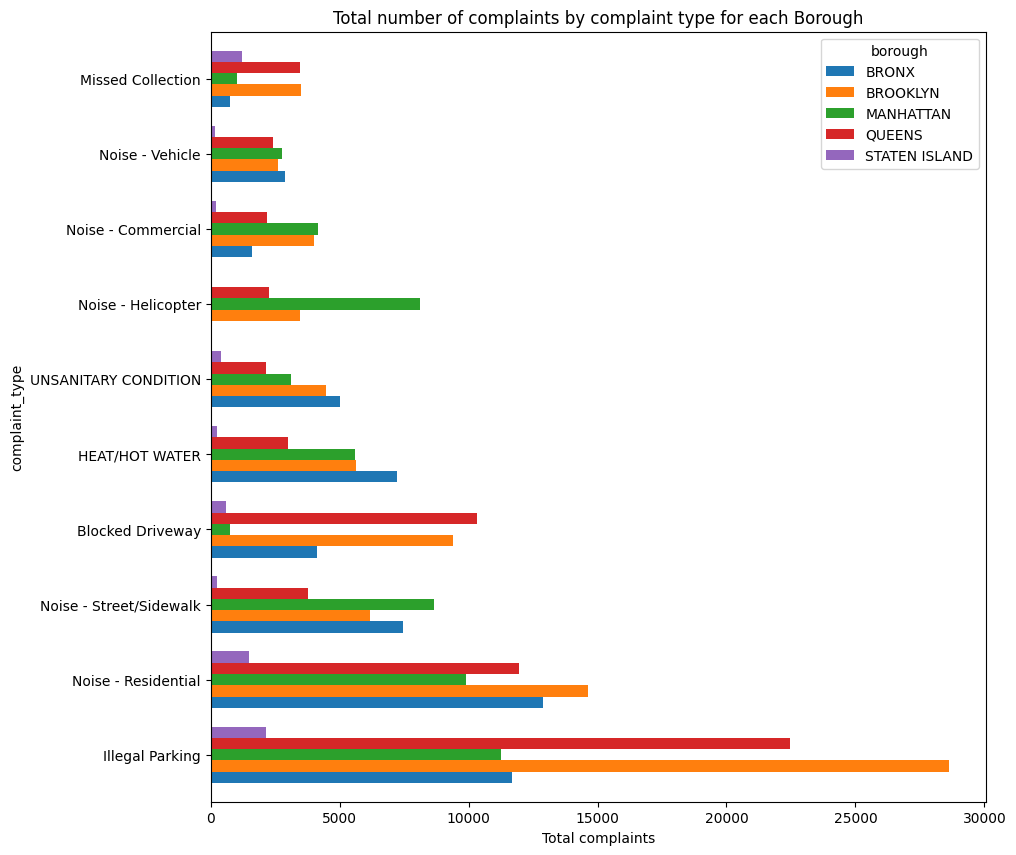

In [11]:
(df_subset4.reindex(index=df_subset4.mean(axis=1)
    .sort_values(ascending=False)
    .index).plot(kind='barh', figsize=(10, 10), width=0.75,
                 title='Total number of complaints by complaint type for each Borough'))
plt.xlabel('Total complaints')
plt.show()

<a class="anchor" id="comment2"></a> 
**Observation:** From the above two plots, it is evident that the highest complaint type in 2023 across most of the boroughs and NYC as a whole is Illegal Parking, followed by Noise - Residential, Heat/Hot water, and the others. 

Bronx has highest complaints related to Heat/Hot water.

### <a class="anchor" id="4.2.Q2"></a>5.2. Analysis-2: Which boroughs are the biggest "complainers" relative to the size of the population in 2023?

#### 5.2.1. Import population data and convert the keys used for merging to the same data type

In [12]:
Data_API = requests.get('https://data.cityofnewyork.us/resource/pri4-ifjk.json')
Pop_Data = Data_API.text
parse_json = json.loads(Pop_Data) #parses the json objects
Pop_Data_df = pd.json_normalize(parse_json) #flatterns the json object to form a dataframe
Pop_Data_df.head()

,modzcta,label,zcta,pop_est,the_geom.type,the_geom.coordinates
0,10001,"10001, 10118","10001, 10119, 10199",23072,MultiPolygon,"[[[[-73.98774438827894, 40.74406551211233], [-..."
1,10002,10002,10002,74993,MultiPolygon,"[[[[-73.99750380833868, 40.714071446737606], [..."
2,10003,10003,10003,54682,MultiPolygon,"[[[[-73.98863576728334, 40.7229309971691], [-7..."
3,10026,10026,10026,39363,MultiPolygon,"[[[[-73.96200720826798, 40.80550908737535], [-..."
4,10004,10004,10004,3028,MultiPolygon,"[[[[-74.00826694529984, 40.707719796661166], [..."


In [13]:
# Include only the essential columns and strip spaces
df2 = Pop_Data_df[['modzcta','pop_est']]

# Strip spaces from the dataframe
for item in df2.columns.tolist():
  df2[item] = df2[item].str.strip()

# Rename columns
df2 = df2.rename(columns={'modzcta': 'incident_zip', 'pop_est': 'population'})

# Convert string to numeric
df2['population']= pd.to_numeric(df2['population'], errors='coerce') 
df2['incident_zip']= pd.to_numeric(df2['incident_zip'], errors='coerce') 

pop = df2.dropna() #delete rows with missing values

# Drop rows with population=0, otherwise it creates complaint-index = infinity
pop.drop(pop[pop['population'] == 0].index, inplace = True) 

# Save the population dataset in Google Drive
pop.to_csv('/content/gdrive/My Drive/Colab Notebooks/311_Service_Request_Analysis/population.csv', index=False) 

pop.head()
# df2.head()

,incident_zip,population
0,10001,23072
1,10002,74993
2,10003,54682
3,10026,39363
4,10004,3028


#### 5.2.2. Create unique zipcode & borough combination table from the original 311 service request dataset

In [14]:
# Convert string to numeric
df_subset = df_subset.dropna()
df_subset['incident_zip'] = df_subset['incident_zip'].astype(int)

Borough_Zip = df_subset[['borough','incident_zip']].drop_duplicates()
Borough_Zip = Borough_Zip.dropna() # dropping rows with missing values
Borough_Zip.head()

,borough,incident_zip
26,BRONX,10454
60,BRONX,10463
71,BRONX,10453
85,BROOKLYN,11238
89,QUEENS,11372


#### 5.2.3. Calculate total number of complaints by zip code

In [15]:
total_complaints_freq_all = df_subset['incident_zip'].value_counts().tolist() #list with frequencies of the complaints
total_complaints_all = df_subset['incident_zip'].value_counts().index.tolist() #list with index of zipcodes
total_complaints_freq_all = pd.DataFrame(total_complaints_freq_all, columns=['num_complaints'])
total_complaints_all = pd.DataFrame(total_complaints_all, columns=['incident_zip'])
df_subset5 = pd.concat([total_complaints_all, total_complaints_freq_all], axis=1)
df_subset5.shape

(220, 2)

#### 5.2.4. Merge population dataset with the above total number of complaints dataset using zip code as the key

In [16]:
df_subset6 = df_subset5.merge(pop, on='incident_zip', how='left') #Left join merge
print(pop.shape)
print(df_subset6.shape) # checking if the merged table has same no. of obs as the left-side dataset

# Save the merged dataset in Google Drive
df_subset6.to_csv('/content/gdrive/My Drive/Colab Notebooks/311_Service_Request_Analysis/df_subset6.csv', index=False) 

df_subset6.head()

(177, 2)
(220, 3)


,incident_zip,num_complaints,population
0,11385,6408,106717.0
1,11226,6329,100277.0
2,10468,5823,78647.0
3,10467,5764,103732.0
4,11201,5712,62823.0


#### 5.2.5. Merging Borough Zip table with total number of complaints dataset to estimate complaint-index (total complaints relative to their population) for each borough of NYC

In [17]:
df_subset7 = df_subset6.merge(Borough_Zip, on='incident_zip', how='left') #Left join merge
df_subset7 = df_subset7.dropna() 

# Aggregate the number of complaints and population for each borough
df_subset8 = df_subset7.groupby(['borough'])[['num_complaints','population']].sum()

# Complaint-index at borough-level
df_subset8['complaint_index'] = df_subset8['num_complaints']/df_subset8['population']

print(Borough_Zip.shape)
print(df_subset8.shape) # checking if the merged table has same no. of obs as the left-side dataset

df_subset8.reset_index(inplace=True) # onverts labels to column
df_subset9 = df_subset8[['borough','complaint_index']]
df_subset9.head()

(222, 2)
(5, 3)


,borough,complaint_index
0,BRONX,0.055515
1,BROOKLYN,0.048793
2,MANHATTAN,0.049610
3,QUEENS,0.045483
4,STATEN ISLAND,0.036414


#### <a class="anchor" id="4.2.6.Fig3"></a>5.2.6. Plot of Complaint-index (total complaints relative to their population) for each Borough in 2023

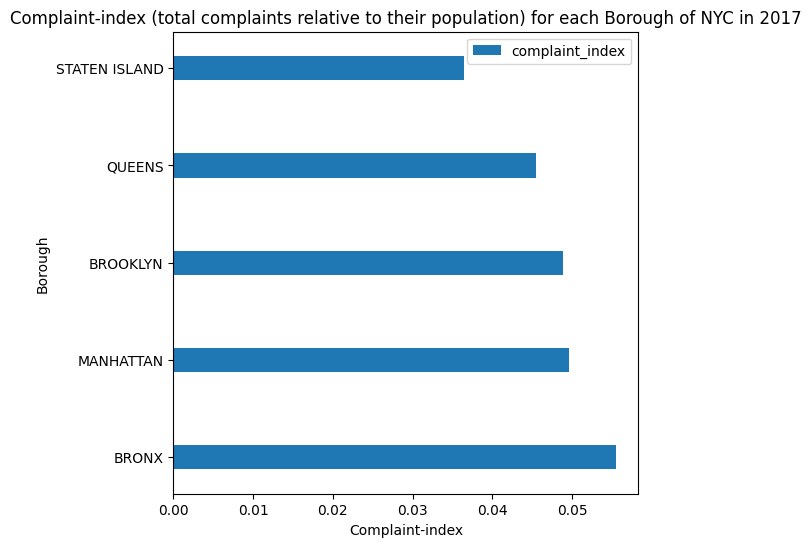

In [18]:
(df_subset9.reindex(index=df_subset9.mean(axis=1)
    .sort_values(ascending=False)
    .index).set_index('borough').plot(kind='barh', figsize=(6,6), width=0.25)) #renaming bar plot index values
plt.ylabel('Borough')
plt.xlabel('Complaint-index')
plt.title("Complaint-index (total complaints relative to their population) for each Borough of NYC in 2023") 
plt.show()

<a class="anchor" id="comment3"></a> 
**Observation:** From the above plot, Bronx has the most number of complaints relative to the size of its population in 2023, followed by Brooklyn, Queens, Manhattan, and Staten Island.

## 5.3. <a class="anchor" id="4.3.Q3"></a>Analysis-3: Run the Complaint index focusing on one or two complaint types you’re curious about.

#### Here, I will analyze two of the most frequent complaint types- 'Illegal Parking' & 'Noise - Residential'

#### 5.3.1. Calculate total number of complaints by complaint type by zipcode

In [19]:
# List of frequencies of the complaints
ct_total_complaints_freq_all = df_subset[['incident_zip','complaint_type']].value_counts().tolist()

# List of index of zipcodes
ct_total_complaints_all = df_subset[['incident_zip','complaint_type']].value_counts().index.tolist() 

# Convert these lists to dataframes
ct_total_complaints_freq_all = pd.DataFrame(ct_total_complaints_freq_all, columns=['num_complaints'])
ct_total_complaints_all = pd.DataFrame(ct_total_complaints_all, columns=['incident_zip','complaint_type'])

# Column bind to form one dataset
df_subset10 = pd.concat([ct_total_complaints_all, ct_total_complaints_freq_all], axis=1) 

# Include observations of the two compaint types of interest 
df_subset11 = df_subset10[df_subset10['complaint_type'].isin(['Illegal Parking', 'Noise - Residential'])]
print(df_subset11.shape)
df_subset11.head()

(385, 3)


,incident_zip,complaint_type,num_complaints
0,11201,Illegal Parking,2750
1,11101,Illegal Parking,2000
2,11385,Illegal Parking,1927
4,11222,Illegal Parking,1413
5,10466,Noise - Residential,1360


#### 5.3.2. Merge poulation dataset with the above total number of complaints dataset using zip code as key

In [20]:
df_subset12 = df_subset11.merge(pop, on='incident_zip', how='left') # Left join merge
print(pop.shape)
print(df_subset12.shape) # checking if the merged table has same no. of obs as the left-side dataset

(177, 2)
(385, 4)


#### 5.3.3. Merging Borough table with the total number of complaints dataset to estimate complaint-index (total complaints relative to their population) for each Borough in 2023

In [21]:
df_subset13 = df_subset12.merge(Borough_Zip, on='incident_zip', how='left') #Left join merge
df_subset13 = df_subset13.dropna() 

# Aggregating number of complaints and population by borough and complaint type
df_subset14 = df_subset13.groupby(['borough','complaint_type'])[['num_complaints','population']].sum()

# Complaint-index at borough-level for each complaint type
df_subset14['complaint_index'] = df_subset14['num_complaints']/df_subset14['population']

print(Borough_Zip.shape)
print(df_subset14.shape) # checking if the merged table has same no. of obs as the left-side dataset

df_subset14.reset_index(inplace=True) # converts labels to column
df_subset15 = df_subset14[['borough','complaint_type','complaint_index']]

# Convert the dataframe long to wide format for plots
df_subset16 = df_subset15.pivot(index='borough', columns='complaint_type', values='complaint_index') 
df_subset16.reset_index(inplace=True) # converts labels to column
print(df_subset16.head())

(222, 2)
(10, 3)
complaint_type        borough  Illegal Parking  Noise - Residential
0                       BRONX         0.008108             0.008907
1                    BROOKLYN         0.010875             0.005509
2                   MANHATTAN         0.007023             0.006201
3                      QUEENS         0.009634             0.005211
4               STATEN ISLAND         0.004556             0.003107


#### <a class="anchor" id="4.3.4.Fig4"></a>5.3.4. Plot of Complaint-index (total complaints relative to their population) of the two complaint types for each Borough in NYC in 2023'

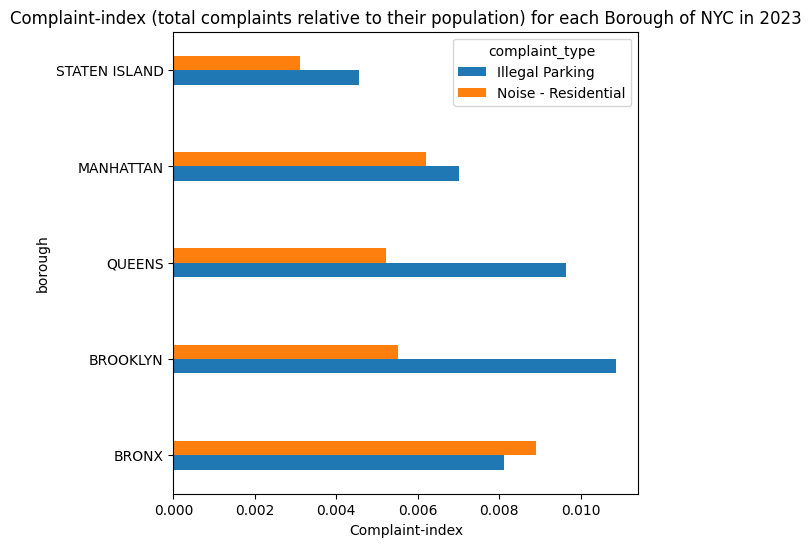

In [23]:
(df_subset16.reindex(index=df_subset16.mean(axis=1)
    .sort_values(ascending=False)
    .index).set_index('borough').plot(kind='barh', figsize=(6,6), width=0.3,
            title='Complaint-index (total complaints relative to their population) for each Borough of NYC in 2023'))
plt.xlabel('Complaint-index')
plt.show()

<a class="anchor" id="comment4"></a> **Observation:** From the above plot, Brooklyn and Bronx have the highest complaint indices on an average, wheras the other three boroughs are not far behind from them. With regard to the variance of the complaint-indices, the level of 'Noise - Residential' seems to be smaller across all the boroughs in NYC compared to the variance for 'illegal parking' complaint indices.


# <a class="anchor" id="5.TS"></a> 6. Time Series / Exploratory Analysis

### 6.1. <a class="anchor" id="5.1.Q1"></a> Analysis-1: 
### Focus on complaints for “Loud Music / Party”. Create a graph of the rate of complaints by population over time for the city overall and each of the boroughs. Comment on any notable trends.

#### 6.1.1. Create a subset which has complaint descriptor variable - 'Loud music/Party'

In [24]:
Loud_music = data[data['descriptor'].isin(['Loud Music/Party'])]
Loud_music['incident_zip'] = pd.to_numeric(Loud_music['incident_zip'], errors='coerce') # convert string to numeric
Loud_music.shape

# Save the merged dataset in Google Drive
Loud_music.to_csv('/content/gdrive/My Drive/Colab Notebooks/311_Service_Request_Analysis/Loud_music.csv', index=False)

#### 6.1.2. Calculate total number of complaints by descriptor by zipcode each month in 2021

In [25]:
# List of frequencies of the complaints
LM_total_complaints_freq_all = Loud_music[['incident_zip','Year_month','Year','Month']].value_counts().tolist() 
# List of index of zipcodes
LM_total_complaints_all = Loud_music[['incident_zip','Year_month','Year','Month']].value_counts().index.tolist() 

# Convert lists to dataframes
LM_total_complaints_freq_all = pd.DataFrame(LM_total_complaints_freq_all, columns=['num_complaints'])
LM_total_complaints_all = pd.DataFrame(LM_total_complaints_all, columns=['incident_zip','Year_month','Year','Month'])

# Combine dataframes to form one
Loud_music2 = pd.concat([LM_total_complaints_all, LM_total_complaints_freq_all], axis=1)
print(Loud_music2.shape)
Loud_music2.head()

(498, 5)


,incident_zip,Year_month,Year,Month,num_complaints
0,10031.0,2023-04,2023,4,1112
1,10466.0,2023-05,2023,5,784
2,10453.0,2023-05,2023,5,754
3,10452.0,2023-05,2023,5,746
4,10457.0,2023-05,2023,5,746


#### 6.1.3. Merge Loud music dataset with population & Borough-Zip datasets

In [26]:
Loud_music3 = Loud_music2.merge(pop, on='incident_zip', how='left')
Loud_music4 = Loud_music3.merge(Borough_Zip, on='incident_zip', how='left') #Left join merge
Loud_music4 = Loud_music4.dropna() 
Loud_music4.head()

,incident_zip,Year_month,Year,Month,num_complaints,population,borough
0,10031.0,2023-04,2023,4,1112,60254.0,MANHATTAN
1,10466.0,2023-05,2023,5,784,72479.0,BRONX
2,10453.0,2023-05,2023,5,754,79606.0,BRONX
3,10452.0,2023-05,2023,5,746,76078.0,BRONX
4,10457.0,2023-05,2023,5,746,74554.0,BRONX


#### 6.1.4. Create complaint-index variable & complaint-rate variable to form dataset by borough

In [27]:
# Aggregating num_complaints and population by borough, month, year
Loud_music5 = Loud_music4.groupby(['borough','Year_month','Month','Year'])[['num_complaints','population']].sum()

# Complaint-index variable
Loud_music5['complaint_index'] = Loud_music5['num_complaints']/Loud_music5['population']

# Add lag of complaint_index variable by zipcode by month
Loud_music5['complaint_index_1'] = Loud_music5.sort_values(['borough','Year_month','Month','Year'],ascending=True)['complaint_index'].shift(1)

# Add complaint-rate variable which is the growth rate in complaint index
Loud_music5['complaint_rate'] = (Loud_music5['complaint_index']-Loud_music5['complaint_index_1'])/Loud_music5['complaint_index_1']

Loud_music5 = Loud_music5.sort_values(['borough','Year_month','Month','Year'],ascending=True) #sort by group
Loud_music5.reset_index(inplace=True) #converts labels to column
print(Loud_music5.shape)
Loud_music5.head()

(15, 9)


,borough,Year_month,Month,Year,num_complaints,population,complaint_index,complaint_index_1,complaint_rate
0,BRONX,2023-03,3,2023,138,1364224.0,0.000101,NaN,NaN
1,BRONX,2023-04,4,2023,7080,1441455.0,0.004912,0.000101,47.555538
2,BRONX,2023-05,5,2023,8853,1441455.0,0.006142,0.004912,0.250424
3,BROOKLYN,2023-03,3,2023,188,2397136.0,0.000078,0.006142,-0.987230
4,BROOKLYN,2023-04,4,2023,7461,2600747.0,0.002869,0.000078,35.579163


#### <a class="anchor" id="5.1.5.Fig5"></a>6.1.5. Monthly plot of complaint-rates by each Borough for entire duration of the dataset

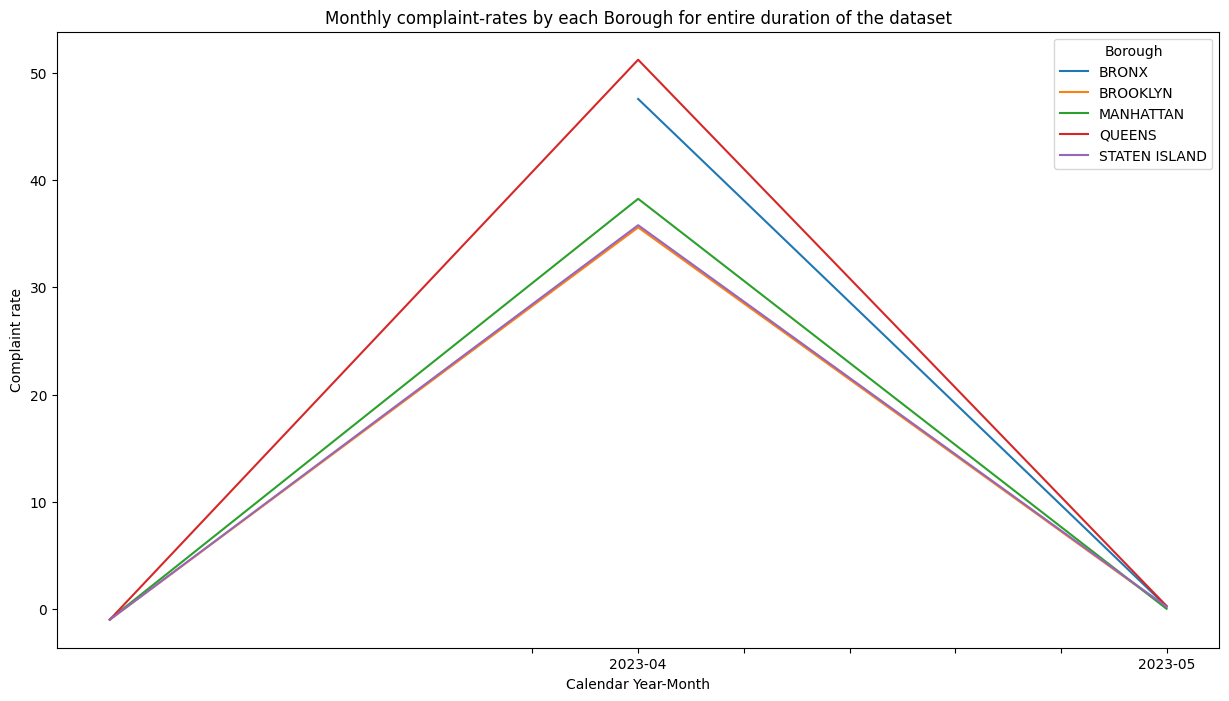

In [30]:
fig, ax = plt.subplots(figsize=(15,8))

for name, group in Loud_music5.groupby('borough'):
    group.plot(x='Year_month', y='complaint_rate', ax=ax, label=name)

plt.xlabel('Calendar Year-Month')
plt.ylabel('Complaint rate')
plt.legend(title = "Borough")
plt.title("Monthly complaint-rates by each Borough for entire duration of the dataset") 
plt.show()

#### 6.1.6. Create complaint-index variable & complaint-rate variable to form dataset for the entire city

In [29]:
# Aggregating num_complaints and population by borough, month, year
Loud_music6 = Loud_music4.groupby(['Year_month','Month','Year'])[['num_complaints','population']].sum()

# Complaint-index variable
Loud_music6['complaint_index'] = Loud_music6['num_complaints']/Loud_music6['population']

# Add lag of complaint_index variable by zipcode by month
Loud_music6['complaint_index_1'] = Loud_music6.sort_values(['Year_month','Month','Year'],ascending=True)['complaint_index'].shift(1)

# Add complaint-rate variable which is the growth rate in complaint index
Loud_music6['complaint_rate'] = (Loud_music6['complaint_index']-Loud_music6['complaint_index_1'])/Loud_music6['complaint_index_1']

Loud_music6 = Loud_music6.sort_values(['Year_month','Month','Year'],ascending=True) # sort by group
Loud_music6.reset_index(inplace=True) # converts labels to column

Loud_music6.head()

,Year_month,Month,Year,num_complaints,population,complaint_index,complaint_index_1,complaint_rate
0,2023-03,3,2023,606,7252349.0,0.000084,NaN,NaN
1,2023-04,4,2023,29497,8604523.0,0.003428,0.000084,40.025806
2,2023-05,5,2023,34719,8610116.0,0.004032,0.003428,0.176270


#### <a class="anchor" id="5.1.7.Fig6"></a> 6.1.7. Monthly plot of complaint-rates for NYC for entire duration of the dataset

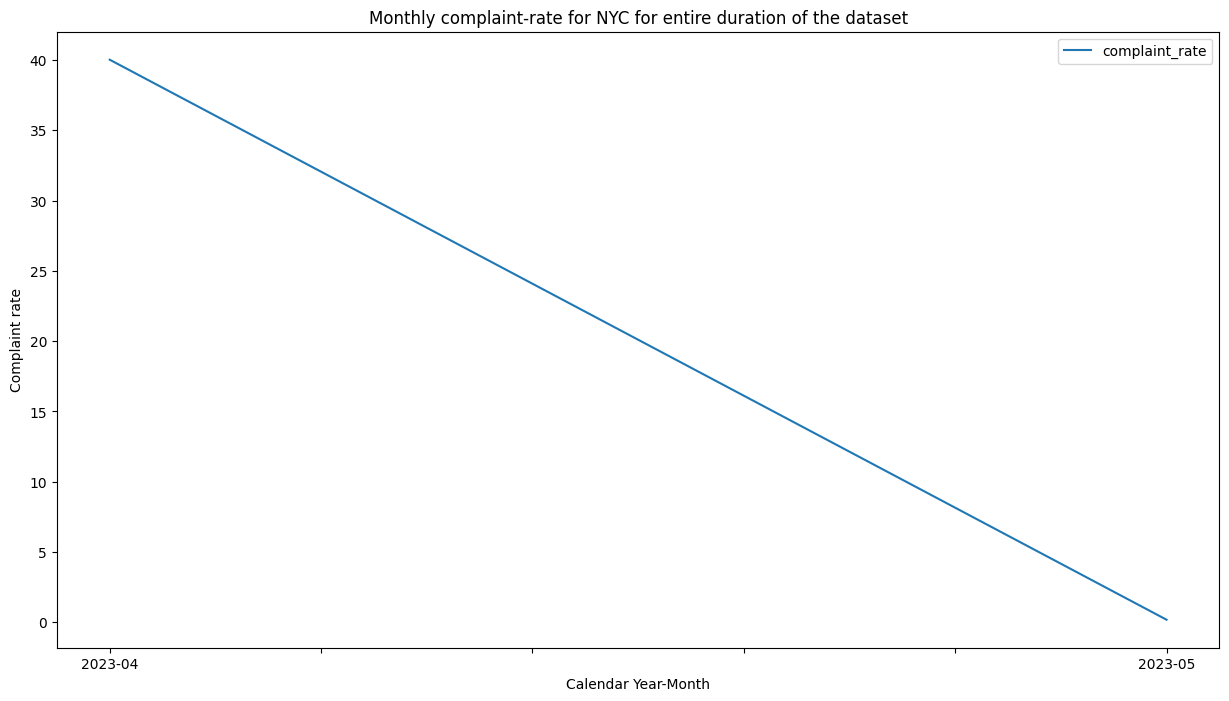

In [31]:
fig, ax = plt.subplots(figsize=(15,8))

Loud_music6.plot(x='Year_month', y='complaint_rate', ax=ax)

plt.xlabel('Calendar Year-Month')
plt.ylabel('Complaint rate')
plt.title("Monthly complaint-rate for NYC for entire duration of the dataset") 
plt.show()

<a class="anchor" id="comment5"></a> **Observation:**  The above two plots imply that the complaint rates have gone down from April to May of this year. However we cannot generalize the results as the data here is only for two months.

## <a class="anchor" id="5.2.Q2"></a> 6.2. Analysis-2: Which zip codes have shown the largest increase in these complaints over time? Develop some filter to make sure that the growth rates aren’t merely an artifact of low volumes.

#### 6.2.1. Create complaint-index variable & complaint-rate variable by zipcode by each month for entire duration of the dataset

In [32]:
Loud_music8 = Loud_music4.copy()

# Complaint-index variable
Loud_music8['complaint_index'] = Loud_music8['num_complaints']/Loud_music8['population']

# Add lag of complaint_index variable by zipcode by month
Loud_music8['complaint_index_1'] = Loud_music8.sort_values(['incident_zip','Year_month','Month','Year'],ascending=True)['complaint_index'].shift(1)

# Add complaint-rate variable which is the growth rate in complaint index
Loud_music8['complaint_rate'] = (Loud_music8['complaint_index']-Loud_music8['complaint_index_1'])/Loud_music8['complaint_index_1']

Loud_music8 = Loud_music8.sort_values(['incident_zip','Year_month','Month','Year'],ascending=True) #sort by group
Loud_music8.reset_index(inplace=True) #converts labels to column
Loud_music8.head()

,index,incident_zip,Year_month,Year,Month,num_complaints,population,borough,complaint_index,complaint_index_1,complaint_rate
0,241,10001.0,2023-04,2023,4,72,23072.0,MANHATTAN,0.003121,NaN,NaN
1,220,10001.0,2023-05,2023,5,87,23072.0,MANHATTAN,0.003771,0.003121,0.208333
2,427,10002.0,2023-03,2023,3,3,74993.0,MANHATTAN,0.000040,0.003771,-0.989391
3,18,10002.0,2023-04,2023,4,545,74993.0,MANHATTAN,0.007267,0.000040,180.666667
4,20,10002.0,2023-05,2023,5,529,74993.0,MANHATTAN,0.007054,0.007267,-0.029358


#### 6.2.1.2. Estimating mean of complaint-rates for entire duration of the dataset by zipcode

I estimate the means of complaint rates by zip code to check which zip codes have higher average growth rate

In [33]:
Loud_music9 = Loud_music8.groupby(['incident_zip','population'])[['num_complaints','complaint_index','complaint_rate']].mean()
Loud_music9.reset_index(inplace=True) #converts labels to column
Loud_music9 = Loud_music9.sort_values(['complaint_rate'],ascending=False) # sort by complaint_rate
Loud_music9a = Loud_music9[:20] # 20 largest zipcodes in terms of the increase in complaints

#### <a class="anchor" id="5.2.2.Fig6"></a> 6.2.2. Scatter plot of Complaint rate vs Complaint Index at Zipcode level for entire duration of the dataset

I then plot the scatter plot to look for anomalies/outliers either in complaint rates or complaint index or population

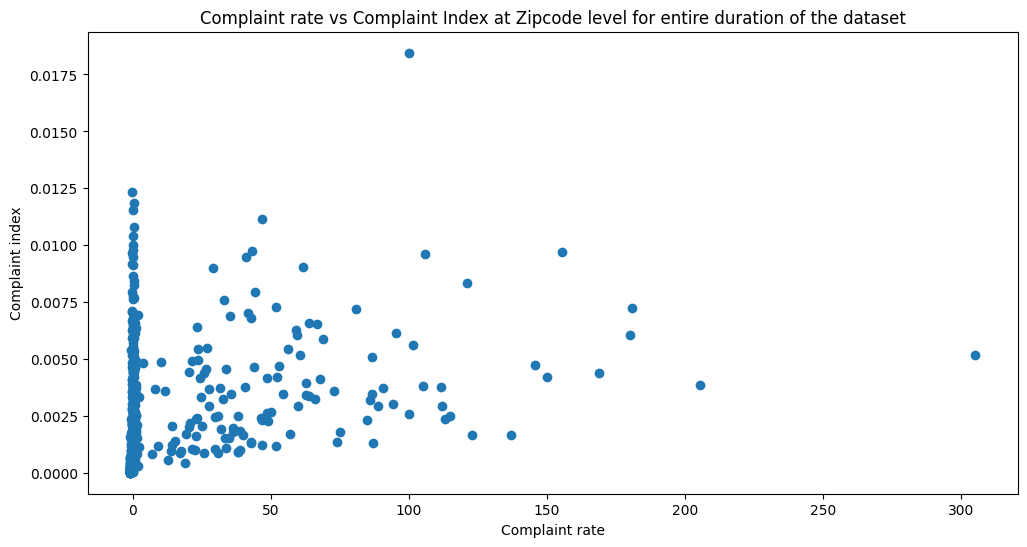

In [34]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(Loud_music8['complaint_rate'],Loud_music8['complaint_index'])
ax.set_xlabel('Complaint rate')
ax.set_ylabel('Complaint index')
plt.title("Complaint rate vs Complaint Index at Zipcode level for entire duration of the dataset")
plt.show()

<a class="anchor" id="comment6"></a> **Observation:** From the above scatter plot, there are a few outliers (too far from the cluster), wherein the complaint index (number of complaints to population ratio) is low but complaint rates (rate of change of complaint index) are high, and vice versa. Hence, I winsorize the extreme 10 percentile values of the variables - population, number of complaints, and complaint index variables below to eliminate these outliers (meaning, replace observations less than 10 and greater than 90 percentile values with 10 and 90 values respectively).

#### 6.2.2.1. Print 10 and 90 percentile values

In [36]:
print(Loud_music8['population'].quantile(0.10))
print(Loud_music8['population'].quantile(0.90))
print(Loud_music8['num_complaints'].quantile(0.10))
print(Loud_music8['num_complaints'].quantile(0.90))

19043.800000000003
89651.60000000002
2.0
374.0


#### 6.2.2.2. Winsorize the variables - complaint index and complaint rate

In [37]:
Loud_music8['population'] = np.where(Loud_music8['population'] < Loud_music8['population'].quantile(0.10), Loud_music8['population'].quantile(0.10), Loud_music8['population'])
Loud_music8['population'] = np.where(Loud_music8['population'] > Loud_music8['population'].quantile(0.90), Loud_music8['population'].quantile(0.90), Loud_music8['population'])
Loud_music8['num_complaints'] = np.where(Loud_music8['num_complaints'] < Loud_music8['num_complaints'].quantile(0.10), Loud_music8['num_complaints'].quantile(0.10), Loud_music8['num_complaints'])
Loud_music8['num_complaints'] = np.where(Loud_music8['num_complaints'] > Loud_music8['num_complaints'].quantile(0.90), Loud_music8['num_complaints'].quantile(0.90), Loud_music8['num_complaints'])

#### 6.2.3. Post winsorization, create complaint-index variable by zipcode by each month for entire duration of the dataset

In [38]:
# Complaint-index variable
Loud_music8['complaint_index']=Loud_music8['num_complaints']/Loud_music8['population']

#### 6.2.3.1. Winsorize complaint index variable

In [39]:
print(Loud_music8['complaint_index'].quantile(0.10))
print(Loud_music8['complaint_index'].quantile(0.90))

5.5771453047129094e-05
0.005260773169071123


In [40]:
Loud_music8['complaint_index'] = np.where(Loud_music8['complaint_index'] < Loud_music8['complaint_index'].quantile(0.10), Loud_music8['complaint_index'].quantile(0.10), Loud_music8['complaint_index'])
Loud_music8['complaint_index'] = np.where(Loud_music8['complaint_index'] > Loud_music8['complaint_index'].quantile(0.90), Loud_music8['complaint_index'].quantile(0.90), Loud_music8['complaint_index'])
                                         
                                         
# Add lag of complaint_index variable by zipcode by month
Loud_music8['complaint_index_1']=Loud_music8.sort_values(['incident_zip','Year_month','Month','Year'],ascending=True)['complaint_index'].shift(1)

# Add complaint-rate variable which is the growth rate in complaint index
Loud_music8['complaint_rate']=(Loud_music8['complaint_index']-Loud_music8['complaint_index_1'])/Loud_music8['complaint_index_1']

Loud_music8 = Loud_music8.sort_values(['incident_zip','Year_month','Month','Year'], ascending=True) # sort by group
Loud_music8.head()

,index,incident_zip,Year_month,Year,Month,num_complaints,population,borough,complaint_index,complaint_index_1,complaint_rate
0,241,10001.0,2023-04,2023,4,72.0,23072.0,MANHATTAN,0.003121,NaN,NaN
1,220,10001.0,2023-05,2023,5,87.0,23072.0,MANHATTAN,0.003771,0.003121,0.208333
2,427,10002.0,2023-03,2023,3,3.0,74993.0,MANHATTAN,0.000056,0.003771,-0.985210
3,18,10002.0,2023-04,2023,4,374.0,74993.0,MANHATTAN,0.004987,0.000056,88.420875
4,20,10002.0,2023-05,2023,5,374.0,74993.0,MANHATTAN,0.004987,0.004987,0.000000


#### 6.2.3.2. Scatter plot of Complaint rate vs Complaint Index at Zipcode level for entire duration of the dataset -- after winsorization

This is to make sure that there are no outliers

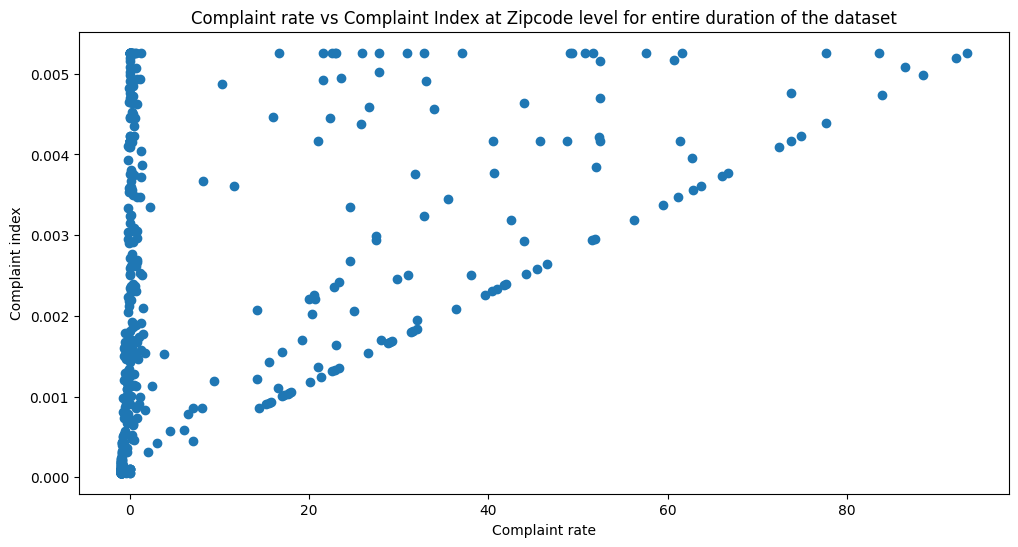

In [41]:
fig, ax = plt.subplots(figsize=(12,6))
ax.scatter(Loud_music8['complaint_rate'],Loud_music8['complaint_index'])
ax.set_xlabel('Complaint rate')
ax.set_ylabel('Complaint index')
plt.title("Complaint rate vs Complaint Index at Zipcode level for entire duration of the dataset")
plt.show()

<a class="anchor" id="comment7"></a> From the above plot, upon eliminating the outliers, it seems like higher average complaint index values have higher average complaint rates and vice versa. So this is an evidence that growth rates are not just a manifestation of low volumes. I also provide a comparison of average complaint indices and average growth rates for the top 20 zip codes below to reaffirm my conclusion.

In [42]:
Loud_music9 = Loud_music8.groupby(['incident_zip','population'])[['num_complaints','complaint_index','complaint_rate']].mean()
Loud_music9.reset_index(inplace=True) # converts labels to column
Loud_music9 = Loud_music9.sort_values(['complaint_rate'],ascending=False) # sort by complaint_rate
Loud_music9b = Loud_music9[:20] # 20 largest zipcodes in terms of the increase in complaints

#### <a class="anchor" id="5.2.3.Tab1"></a> 6.2.3. Zip codes with highest average complaint growth rates before and after winsorization

In [43]:
# Code to display two pandas dataframes side by side
from IPython.display import display_html
from itertools import chain,cycle
def display_side_by_side(*args,titles=cycle([''])):
    html_str=''
    for df,title in zip(args, chain(titles,cycle(['</br>'])) ):
        html_str+='<th style="text-align:center"><td style="vertical-align:top">'
        html_str+=f'<h2>{title}</h2>'
        html_str+=df.to_html().replace('table','table style="display:inline"')
        html_str+='</td></th>'
    display_html(html_str,raw=True)

display_side_by_side(Loud_music9a, Loud_music9b, titles=['Before winsorization','After winsorization'])

,incident_zip,population,num_complaints,complaint_index,complaint_rate
112,11225.0,58882.0,183.000000,0.003108,101.265802
149,11385.0,106717.0,290.333333,0.002721,68.206298
1,10002.0,74993.0,359.000000,0.004787,59.882639
26,10030.0,29882.0,119.666667,0.004005,59.661571
44,10301.0,38733.0,100.000000,0.002582,55.967741
28,10032.0,64264.0,433.000000,0.006738,51.442347
142,11372.0,61844.0,179.333333,0.002900,48.116156
110,11223.0,81789.0,93.000000,0.001137,45.338762
105,11218.0,74508.0,115.333333,0.001548,40.928478
137,11366.0,14650.0,75.666667,0.005165,39.971708


<a class="anchor" id="comment8"></a> From the above datasets, the Incident Zip codes with the highest average complaint rates have higher complaint indices, before and after the winsorization of number of complaints, population, and complaint index values. 